Problem was when an image was filled with 0. This caused the shift function to freak out and crash the kernal.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('../scenes/')
import syndiff as sd 
from delta_kernal import *

In [15]:
# SN2020fqv
#ra = 189.1385827     
#dec = 11.2316599
# sn 2019 pxd
ra = 344.7305444     
dec = 40.9326963
scene, tpf = sd.Catalog_scene(ra,dec,100,Maglim= 17, Sector=16, Catalog='ps1',Interpolate=False,Plot=False)#,Save='PS1_catalog_scene.pdf')

In [7]:
def Isolated_stars(pos,Tmag,flux,Median,sources, Distance = 7, Mag = 16):
    """
    Find isolated stars in the scene.
    """
    #pos, Tmag = sd.Get_PS1(tpf,magnitude_limit=18)
    pos_shift = pos+.5
    ind = ((Distance//2< pos_shift[:,0]) & (pos_shift[:,0]< flux.shape[1]-Distance//2) & 
          (Distance//2< pos_shift[:,1]) & (pos_shift[:,1]< flux.shape[1]-Distance//2) &
          (Tmag < Mag))
    if ~ind.any():
        raise ValueError('No sources brighter than {} Tmag.'.format(Mag))
    p = pos_shift[ind,:]
    distance= np.zeros([len(p),len(p)])
    for i in range(len(p)):
        distance[i] = np.sqrt((p[i,0] - p[:,0])**2 + (p[i,1] - p[:,1])**2)
    distance[distance==0] = np.nan
    mins = np.nanmin(distance,axis=1)
    iso = p[mins > Distance]
    iso = iso.astype('int')
    iso_s = scene[ind]
    iso_s = iso_s[mins > Distance]
    median = Median
    median[median<0] = 0
    print(iso)
    if len(iso)> 0:
        clips = []
        time_series = []
        if (Distance % 2) ==0:
            d = Distance - 1
        else:
            d = Distance
        u = d//2 +1 
        l = d //2 
        
        for i in range(len(iso)):
            clips += [[iso_s[i,iso[i,1]-l:iso[i,1]+u,iso[i,0]-l:iso[i,0]+u],
                     median[iso[i,1]-l:iso[i,1]+u,iso[i,0]-l:iso[i,0]+u]]]
            time_series += [flux[:,iso[i,1]-l:iso[i,1]+u,iso[i,0]-l:iso[i,0]+u]]
        #print(clips)
        clips=np.array(clips)
        time_series=np.array(time_series)
    else:
        raise ValueError('No stars brighter than {} Tmag and isolated by {} pix. Concider lowering brightness.'.format(Mag,Distance))
    return iso, clips, time_series

def Isolated_kernals(Sources,Size=5,Scenes = False,Median = True):
    '''
    Calculate the Delta convolution kernals for isolated sources.
    
    -------
    Inputs-
    -------
        Sources  array   n x 2 array of images. 0 is scene, 1 is observation
        Size     int     Size of the delta kernal
    --------
    Options-
    --------
        Scenes   bool  If True, it uses the provided scene as the template
        Median   bool  If True, returns the median of all delta kernals
        
    -------
    Output-
    -------
        Kernals  array  If Median == True, returns single kernal, if not, 
                        returns n kernal array
        
    '''
    kernals = []
    for i in range(len(Sources)):
        star = Sources[i,1]
        if scenes:
            blank = Sources[i,0]
        else:
            blank = np.zeros_like(test)
            blank[blank.shape[0]//2+1,blank.shape[1]//2+1] = np.nansum(test)
        k = Delta_kernal(blank,test,Size=Size,Normalise=False)
        kernals += [k]
    kernals = np.array(kernals)
    if Median:
        return np.nanmedian(kernals,axis=0)
    else:
        return kernals

In [3]:
cus = np.ones_like(tpf.flux[0])
#cus[20:29,20:29] = 0
cus[32:40,32:40] = 0
bkg = sd.Scene_bkg_estimate(scene,tpf,Limit=.3,Custom_mask=cus)

flux = tpf.flux - bkg
f = flux.copy()
f[f<0] = 0
b = bkg.copy()
b[b==0] = np.nan
me = np.nanmedian(b,axis=0)
ind = np.where(np.nansum(b < me,axis=(1,2)) > (b.shape[1]*2))[0]
low_bkg_flux = flux[ind]
low_bkg_flux[low_bkg_flux==0] = np.nan
median = np.nanmedian(low_bkg_flux,axis=0)
pos, Tmag = sd.Get_PS1(tpf,magnitude_limit=18)

additional mask


/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [5]:
tpf.interact()

No pixels in `aperture_mask`, finding optimum aperture using `tpf.create_threshold_mask`.


<IPython.core.display.Javascript object>


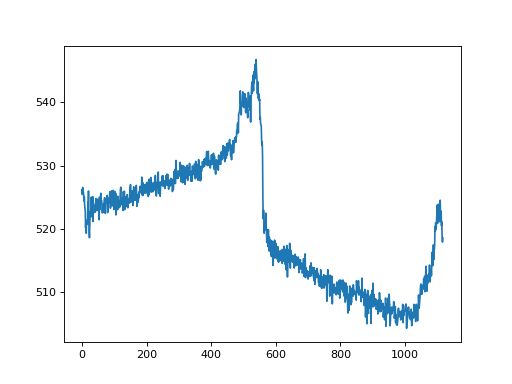

In [4]:
plt.figure()
plt.plot(f[:,25,25])

In [9]:
loc,iso,ts = Isolated_stars(pos,Tmag,f,median,scene,Mag=16,Distance=7)

[]


/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


ValueError: No stars brighter than 16 Tmag and isolated by 7 pix. Concider lowering brightness.

In [5]:
from photutils import centroid_com

In [39]:
def Centroids(Stars,References,Plot=True):
    centroids = np.zeros((Stars.shape[0],Stars.shape[1],2))
    for i in range(len(Stars)):
        star = Stars[i]
        for j in range(len(star)):
            c = centroid_com(star[j])
            ref = centroid_com(References[i])
            c = c - ref
            centroids[i,j] = c
        if Plot:
            Plot_centroids(centroids[i],i)
    return centroids

def Plot_centroids(Centoids,Num,Save=False):
    x = np.arange(0,len(Centoids))
    plt.figure()
    plt.subplot(221)
    plt.scatter(x,Centoids[:,0],marker='.',c=x,alpha = 1)
    plt.ylabel('$\Delta$Column')
    plt.xlabel('Frame')
    plt.subplot(222)
    plt.scatter(x,Centoids[:,1],marker='.',c=x,alpha = 1)
    plt.ylabel('$\Delta$Row')
    plt.xlabel('Frame')
    plt.subplot(212)
    im = plt.scatter(Centoids[:,0],Centoids[:,1],marker='.',c=x,alpha = 1)
    plt.ylabel('$\Delta$Row')
    plt.xlabel('$\Delta$Column')

    plt.suptitle('Reference star {}'.format(Num))
    plt.subplots_adjust(wspace=.35,hspace=.4)
    
    if Save:
        plt.savefig('./Centroids_Star_{}.pdf'.format(Num))
    #plt.tight_layout()


In [132]:
loc,iso,ts = Isolated_stars(pos,Tmag,tpf.flux,median,scene,Mag=16,Distance=7)
c = Centroids(ts,iso[:,1],False)
medc = np.nanmedian(c,axis=0)

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less
/Users/ryanr/miniconda3/lib/python3.7/site-packages/photutils/centroids/core.py:132: RuntimeWarning: invalid value encountered in double_scalars
  for axis in range(data.ndim)])[::-1]


[[39  8]
 [53 19]
 [61 43]
 [12 19]
 [41 56]
 [ 3 45]
 [51 65]]


/Users/ryanr/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [93]:
from scipy.ndimage import shift

In [94]:
f2 = flux.copy()
f2[f2<0] = 0
eh = np.zeros_like(f2)

In [112]:
def Shift_images(Offset,Data):
    shifted = Data.copy()
    data = Data.copy()
    data[data<0] = 0
    for i in range(len(data)):
        if np.nansum(data[i]) > 0:
            shifted[i] = shift(data[i],[Offset[i,0],Offset[i,1]],mode='nearest',order=3)
    return shifted

In [14]:
sd.shift(f[0],[0,0])

array([[ 12.625328  ,   8.327621  ,  38.041534  , ...,   9.705521  ,
         20.562782  ,  19.866547  ],
       [  2.7693176 ,   4.002266  ,  10.231583  , ...,   6.421921  ,
          6.548996  ,   5.229759  ],
       [  0.68601227,   1.4329605 ,   5.680023  , ...,   0.39266205,
          3.9283981 ,   6.7304535 ],
       ...,
       [ 32.400787  ,  11.7899475 ,   5.8667755 , ..., 133.71863   ,
         29.273453  ,   9.638969  ],
       [ 22.795082  ,   9.279808  ,   6.8773804 , ..., 107.06165   ,
         34.123207  ,  14.917824  ],
       [  7.6217804 ,   3.5937576 ,   5.938835  , ..., 217.11224   ,
         53.74537   ,  13.468025  ]], dtype=float32)

In [140]:
t= tpf.flux.copy()
t[np.isnan(t)] = 0
test = Shift_images(medc,tpf.flux)

In [141]:
test

array([[[  0.      ,   0.      ,   0.      , ...,   0.      ,
           0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      , ...,   0.      ,
           0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      , ...,   0.      ,
           0.      ,   0.      ],
        ...,
        [  0.      ,   0.      ,   0.      , ...,   0.      ,
           0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      , ...,   0.      ,
           0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      , ...,   0.      ,
           0.      ,   0.      ]],

       [[  0.      ,   0.      ,   0.      , ...,   0.      ,
           0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      , ...,   0.      ,
           0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      , ...,   0.      ,
           0.      ,   0.      ],
        ...,
        [  0.      ,   0.      ,   0.      , ...,   0.      ,
           0.      ,   0.      ],
        [  0

<IPython.core.display.Javascript object>


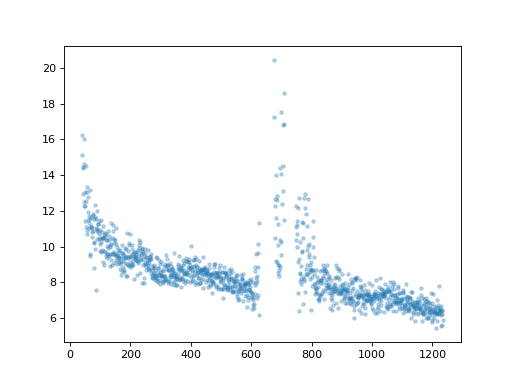

In [142]:
test -= bkg
test[test <= 0] = np.nan
lc = np.nansum(test[:,34:37,34:37],axis=(1,2))
lc[lc==0] = np.nan
plt.figure()
#plt.plot(eh[:,34,35])#-bkg[:,35,36])
plt.plot(test[:,0,3],'.',alpha=.3)
#plt.plot(test[:,0,3],'+',alpha=.5)#-bkg[:,35,36])

#plt.ylim(800,1000)

<IPython.core.display.Javascript object>


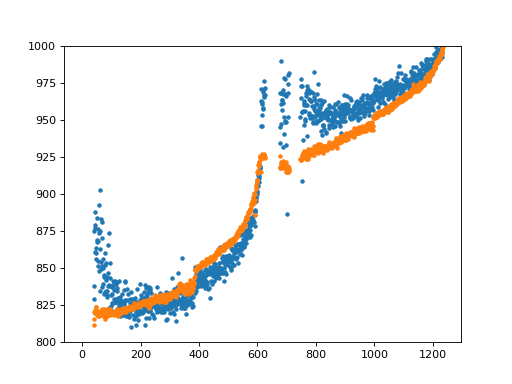

(800, 1000)

In [114]:
test[test == 0] = np.nan
lc = np.nansum(test[:,34:37,34:37],axis=(1,2))
lc[lc==0] = np.nan
plt.figure()
#plt.plot(eh[:,34,35])#-bkg[:,35,36])
plt.plot(test[:,36,35],'.')#-bkg[:,35,36])
plt.plot(flux[:,36,35],'.')
plt.ylim(800,1000)

<IPython.core.display.Javascript object>


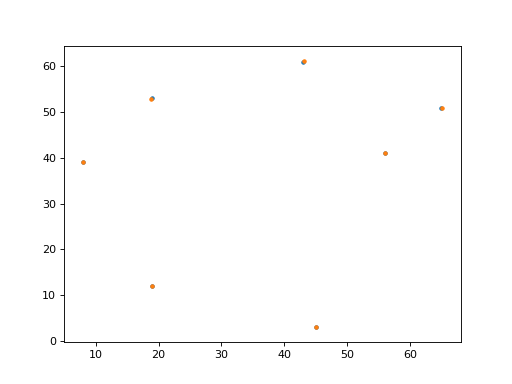

In [38]:
plt.figure()
plt.scatter(loc[:,1],loc[:,0],marker='.')
plt.scatter(c[:,100,0]+loc[:,1]-medc[100,0],c[:,100,1]+loc[:,0]-medc[100,1],marker='.')